# Predicting Bicycle Traffic with Linear Regression Modelling

This notebook follows an linear regression example from the excellent *Python Data Science Handbook* by Jake VanderPlas (O'Reilly). Copyright 2017 Jake VanderPlas, 978-1-491-91205-8. The original code can be found [here](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb).

### Loading libraries and data

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# display all columns in df
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
# load datasets, indexing by date
counts = pd.read_csv('Fremont_Bridge_Hourly_Bicycle_Counts.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('DailyWeather.csv', index_col = 'DATE', parse_dates=True)

In [4]:
counts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52536 entries, 2012-10-03 00:00:00 to 2018-09-30 23:00:00
Data columns (total 2 columns):
Fremont Bridge East Sidewalk    52527 non-null float64
Fremont Bridge West Sidewalk    52527 non-null float64
dtypes: float64(2)
memory usage: 1.2 MB


In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1340 entries, 2012-01-01 to 2015-09-01
Data columns (total 25 columns):
STATION         1340 non-null object
STATION_NAME    1340 non-null object
PRCP            1340 non-null int64
SNWD            1340 non-null int64
SNOW            1340 non-null int64
TMAX            1340 non-null int64
TMIN            1340 non-null int64
AWND            1340 non-null int64
WDF2            1340 non-null int64
WDF5            1340 non-null int64
WSF2            1340 non-null int64
WSF5            1340 non-null int64
FMTM            1340 non-null int64
WT14            1340 non-null int64
WT01            1340 non-null int64
WT17            1340 non-null int64
WT05            1340 non-null int64
WT02            1340 non-null int64
WT22            1340 non-null int64
WT04            1340 non-null int64
WT13            1340 non-null int64
WT16            1340 non-null int64
WT08            1340 non-null int64
WT18            1340 non-null int64
WT03     

### Prepare consolidated dataset

In [6]:
# compute total daily bicycle traffic in new df by resampling
daily = counts.resample('d').sum()  
daily['traffic'] = daily.sum(axis=1)
daily = daily[['traffic']]  # remove other columns

In [7]:
# check
daily.head()

,traffic
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


In [8]:
# add weekdays
days=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [9]:
# check
daily.head()

,traffic,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# add holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [11]:
# check
daily.head()

,traffic,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# add hours of daylight
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute hours of daylight for given date and position."""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

In [13]:
# check
daily.head()

,traffic,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs
Date,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208


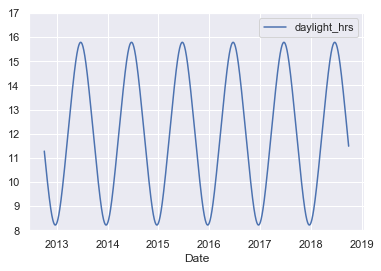

In [14]:
# plot daylight hours
daily[['daylight_hrs']].plot()
plt.ylim(8, 17);

In [15]:
# calculate mean temperatures (temp in weather are in 1/100 deg and have to be converted accordingly)
weather['Temp (C)'] = 100 * 0.5 * (weather['TMIN'] + weather['TMAX'])

# calculate precipitation (prcp in weather is in 1/10 mm and has to be converted accordingly)
weather['PRCP'] = weather['PRCP'] * 10

# calculate flag if the day was dry or not
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

# add these new columns to daily
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

# finally add a counter that increases from day 1, and measures how many years have passed. It will let us measure any 
# observed annual increase or decrease in daily crossings
daily['annual'] = (daily.index - daily.index[0]).days / 365

In [16]:
# check
daily.head()

,traffic,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13350.0,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13600.0,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15300.0,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15850.0,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15850.0,1.0,0.010959


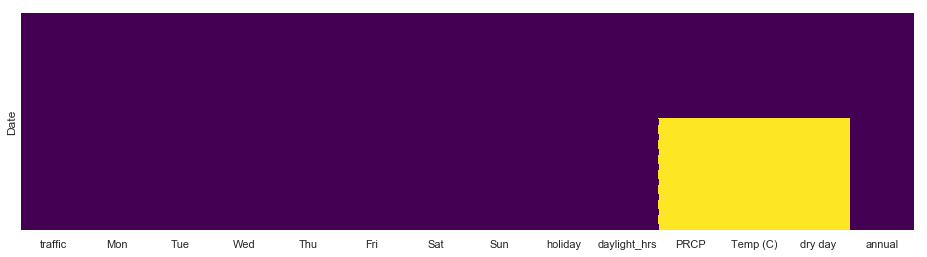

In [17]:
# check for NaN
plt.figure(figsize=(16,4))
sns.heatmap(daily.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [18]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

### Apply linear regression

**Note:** `fit_intersept = False`, because the daily flags essentially operate as their own day-specific intercepts

In [19]:
X = daily.drop('traffic', axis=1)
y = daily['traffic']

model = LinearRegression(fit_intercept=False)
model.fit(X,y)
daily['predicted']= model.predict(X)

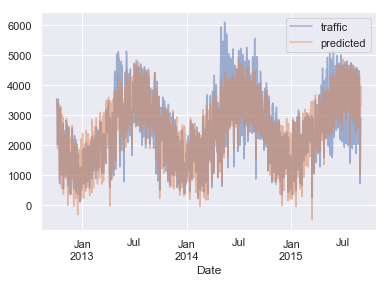

In [20]:
# plot comparision of total and predicted traffic
daily[['traffic', 'predicted']].plot(alpha=0.5);

### Interpreting the results / feature importance

The model is not perfect but this rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count.

In [21]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP              -0.261746
Temp (C)           0.065163
dry day          547.698592
annual            26.942713
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [22]:
# bootstrap resampling of data
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [23]:
# look at the results
params = pd.DataFrame({'effect': params.round(0), 'error': err.round(0)})
print(params)

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP            -0.0    0.0
Temp (C)         0.0    0.0
dry day        548.0   33.0
annual          27.0   18.0


**Interpretation**

We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays. We see that for each additional hour of daylight, 129 ± 9 more people choose to ride; a temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle; a dry day means an average of 548 ± 33 more riders, and each mm of precipitation means 262 ± 25 more people leave their bike at home. Once all these effects are accounted for, we see a modest increase of 27 ± 18 new daily riders each year.

This model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). 

***